In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch

In [2]:
from bmadx import PI, M_ELECTRON, C_LIGHT
from bmadx.bmad_torch.track_torch import Beam
from bmadx.bmad_torch.track_torch import TorchDrift, TorchQuadrupole, TorchCrabCavity, TorchRFCavity, TorchSBend, TorchLattice

In [30]:
def create_6d_diagnostic_beamline():
    # Design momentum
    p_design = 10.0e6 # eV/c
    
    # Quadrupole parameters
    l_q = 1e-3
    k1 = 0.0 # scan parameter
    
    # Drift from Quad to TDC
    l_d1 = 0.165 + 0.105 + 0.165 + 0.3275 - 0.23/2
    
    # transverse deflecting cavity (TDC) parameters
    l_tdc = 0.23
    k_tdc = 2.00 # m^-1
    f_tdc = 1.3e9
    v_tdc = p_design * k_tdc * C_LIGHT / ( 2 * PI * f_tdc )
    phi_tdc = 0.0 #scan parameter (maybe?)
    
    # Drift from TDC to Bend
    l_d2 = 0.633 - 0.23/2
     
    # Bend parameters
    l_bend = 0.365 # arc length
    theta = 20.0 * PI / 180.0 # angle
    g = theta/l_bend # curvature function. positive bends in the -x direction. 
    
    # Drift from Bend to YAG
    l_d3 = 0.895
    
    # Elements:
    q = TorchQuadrupole(L = torch.tensor(l_q),
                        K1 = torch.tensor(k1),
                        NUM_STEPS = 5)
    
    d1 = TorchDrift(L = torch.tensor(l_d1))
    
    tdc = TorchCrabCavity(L = torch.tensor(l_tdc),
                          VOLTAGE = torch.tensor(v_tdc),
                          RF_FREQUENCY = torch.tensor(f_tdc),
                          PHI0 = torch.tensor(phi_tdc),
                          TILT=torch.tensor(PI/2),
                         )
    
    d2 = TorchDrift(L = torch.tensor(l_d2))
    
    bend = TorchSBend(L = torch.tensor(l_bend),
                      P0C = torch.tensor(p_design),
                      G = torch.tensor(g),
                      E1 = torch.tensor(theta/2),
                      E2 = torch.tensor(theta/2)
                     )
    
    d3 = TorchDrift(L = torch.tensor(l_d3))
    
    lattice = TorchLattice([q, d1, tdc, d2, bend, d3])
    
    return lattice

In [31]:
from generate_test_beam import generate_test_beam

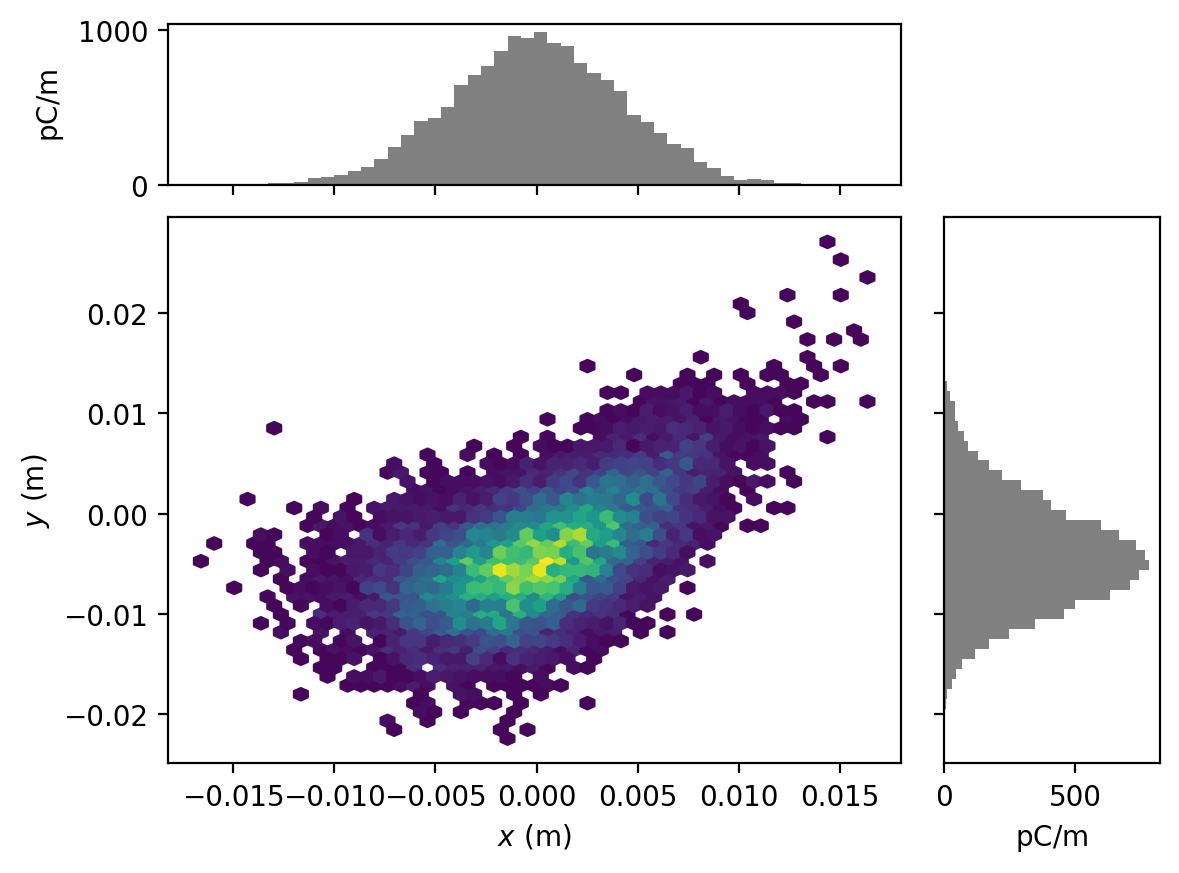

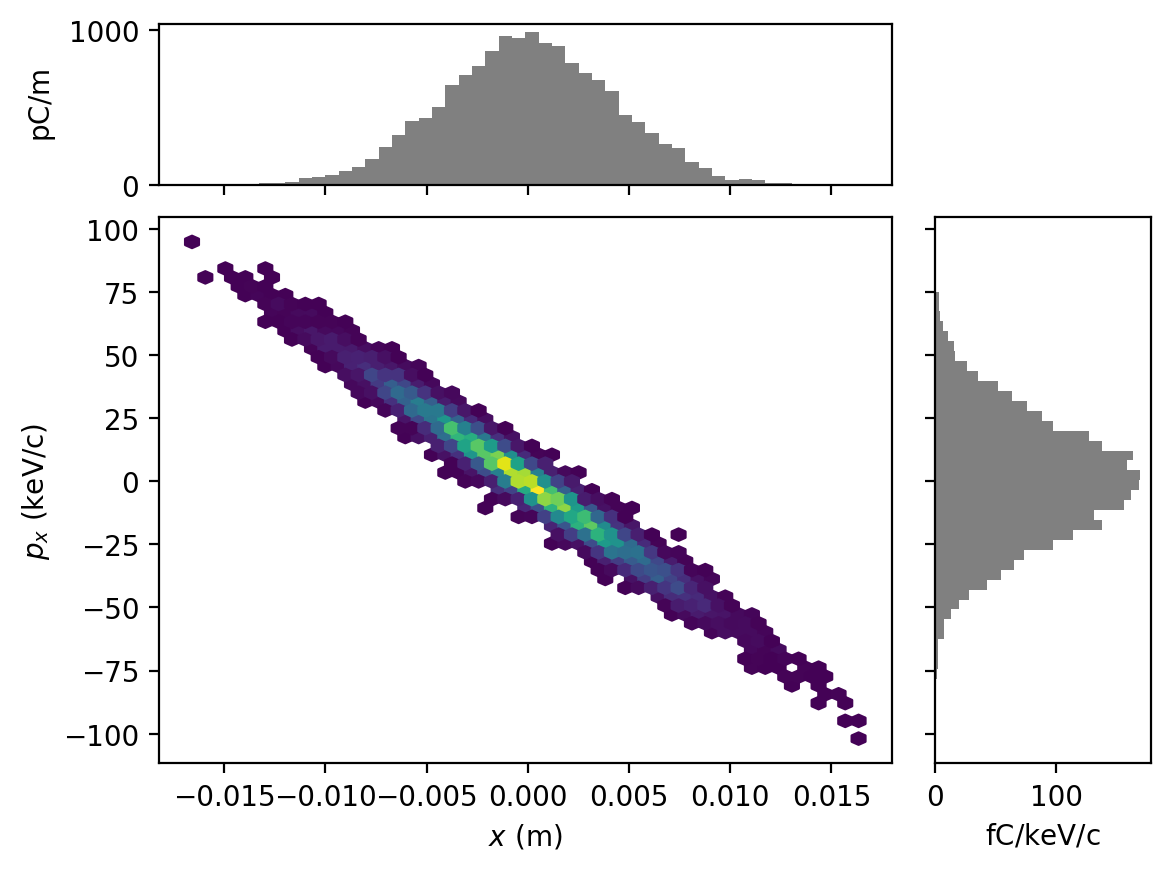

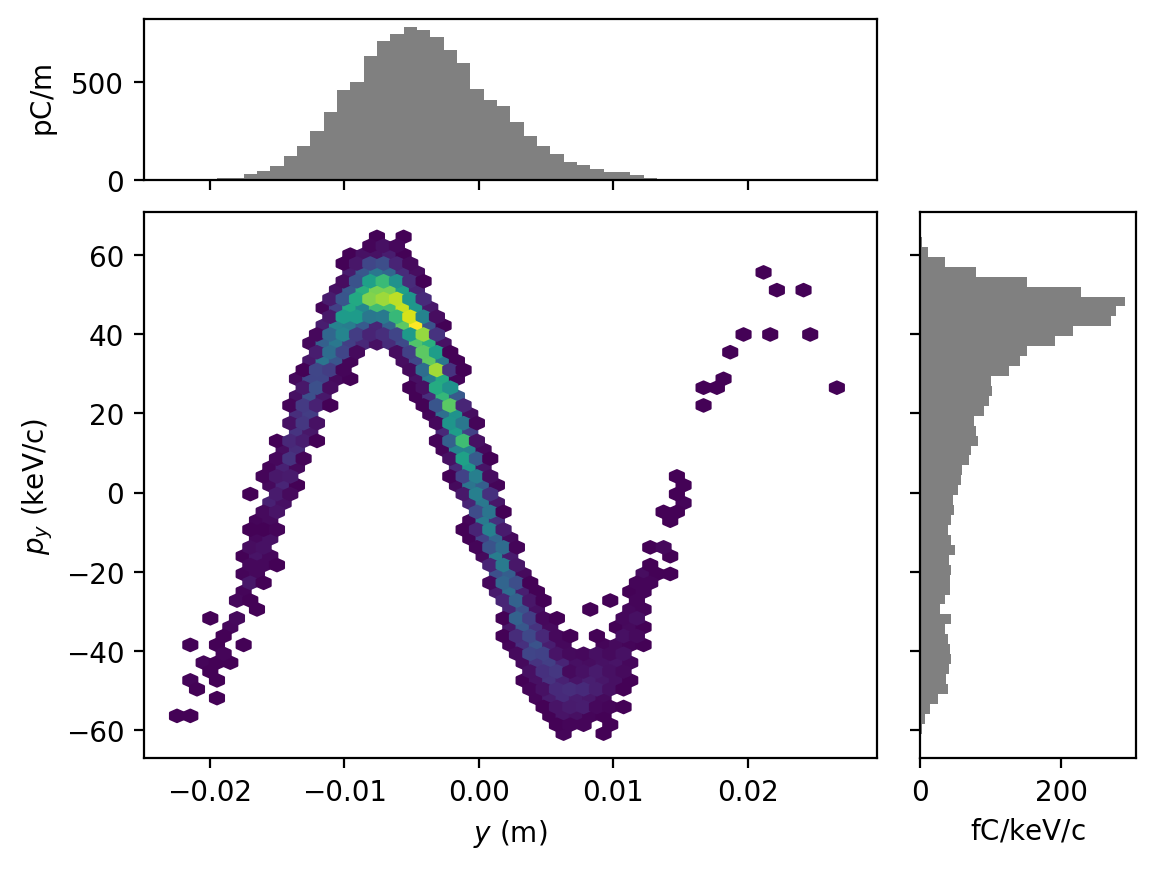

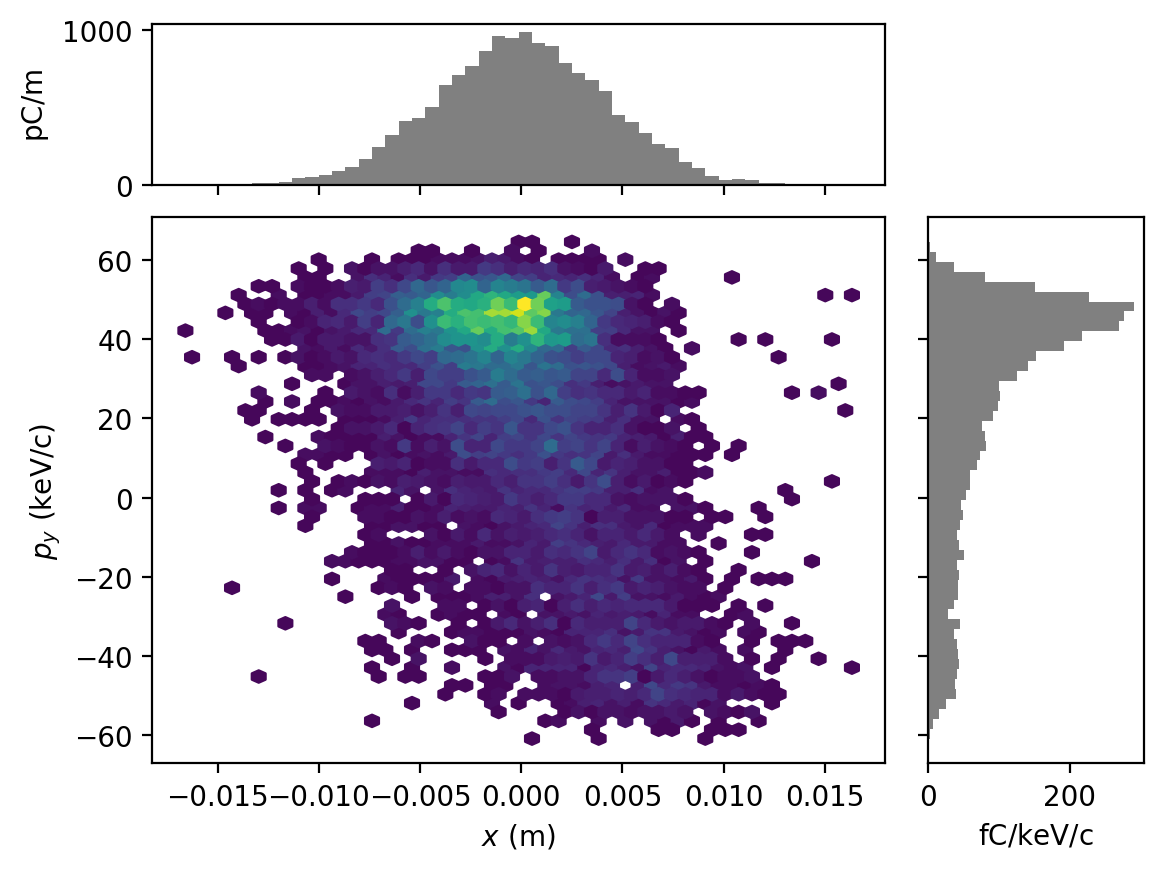

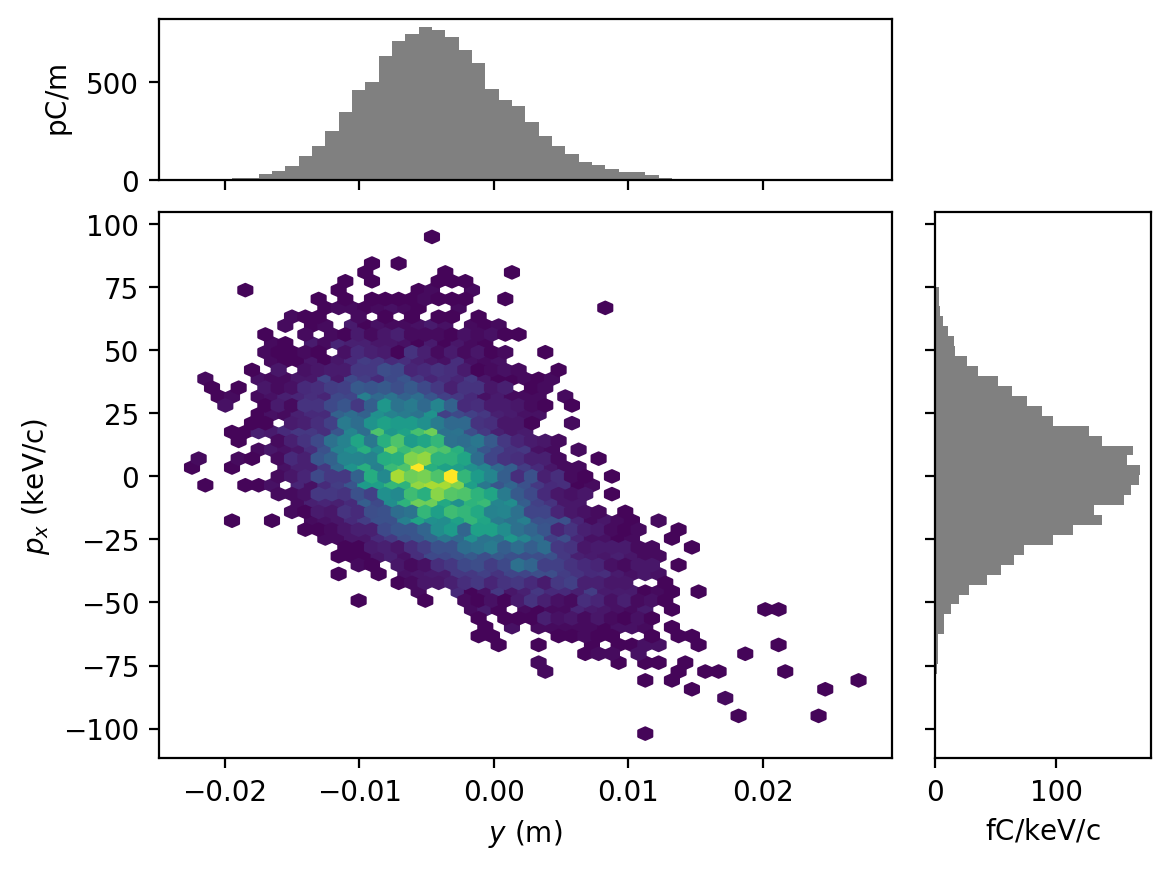

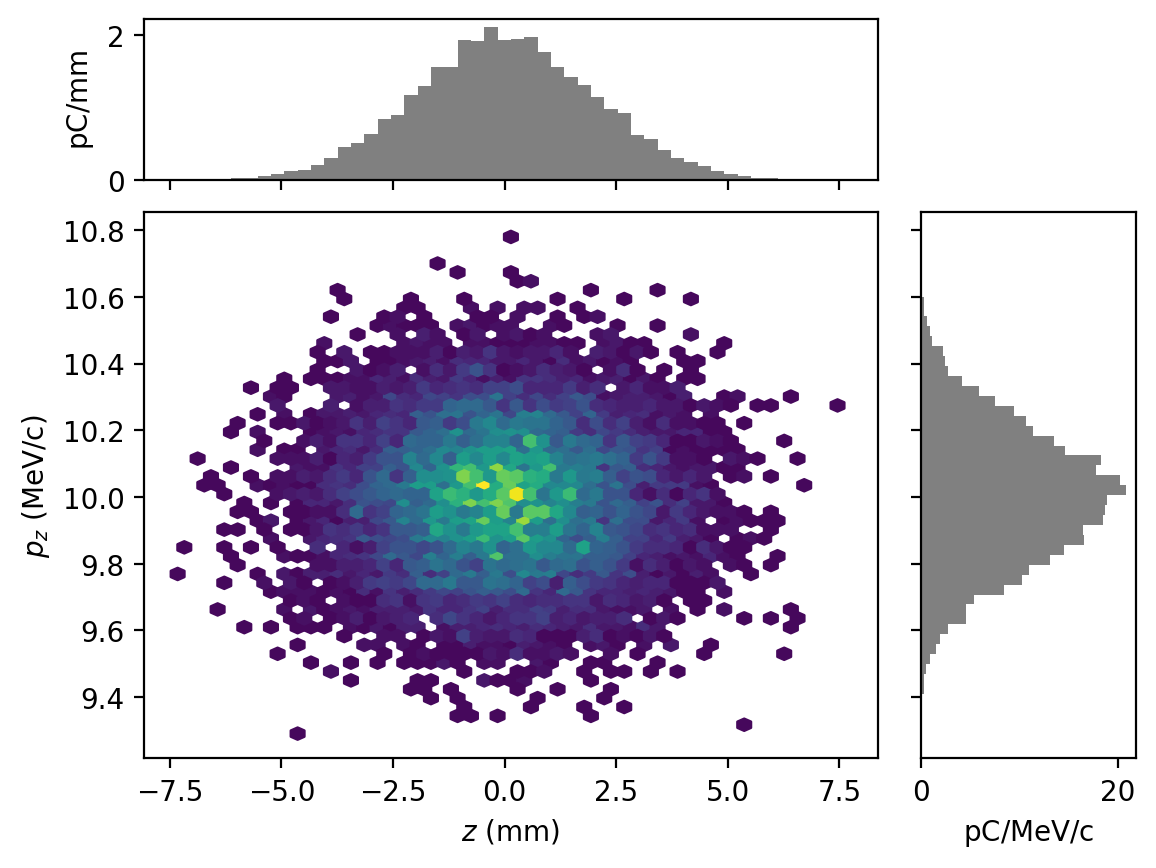

In [32]:
generate_test_beam()

In [33]:
beam_coords = torch.load("ground_truth_dist.pt")

In [34]:
input_beam = Beam(
    beam_coords,
    s=torch.tensor(0.0),
    p0c=torch.mean(beam_coords[:, -1]),
    mc2=torch.tensor(M_ELECTRON),
)

In [35]:
input_beam.p0c

Parameter containing:
tensor(2.9265e-17, dtype=torch.float64)

In [36]:
input_beam = Beam(
    beam_coords,
    s=torch.tensor(0.0),
    p0c=torch.tensor(10.0e6),
    mc2=torch.tensor(M_ELECTRON)
)

In [37]:
input_beam.p0c

Parameter containing:
tensor(10000000.)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.04  , -0.0392, -0.0384, -0.0376, -0.0368, -0.036 , -0.0352,
        -0.0344, -0.0336, -0.0328, -0.032 , -0.0312, -0.0304, -0.0296,
        -0.0288, -0.028 , -0.0272, -0.0264, -0.0256, -0.0248, -0.024 ,
        -0.0232, -0.0224, -0.0216, -0.0208, -0.02  , -0.0192, -0.0184,
        -0.0176, -0.0168, -0.016 , -0.0152, -0.0144, -0.0136, -0.0128,
        -0.012 , -0.0112, -0.0104, -0.0096, -0.0088, -0.008 , -0.0072,
        -0.0064, -0.0056, -0.0048, -0.004 , -0.0032, -0.0024, -0.0016,
        -0.0008,  0.    ,  0.0008,  0.0016,  0.0024,  0.0032,  0.004 ,
         0.0048,  0.0056,  0.0064,  0.0072,  0.008 ,  0.0088,  0.0096,
         0.0104,  0.0112,  0.012 ,  0.0128,  0.0136,  0.0144,  0.0152,
         0.016 ,  0.0168,  0.0176,  0.018

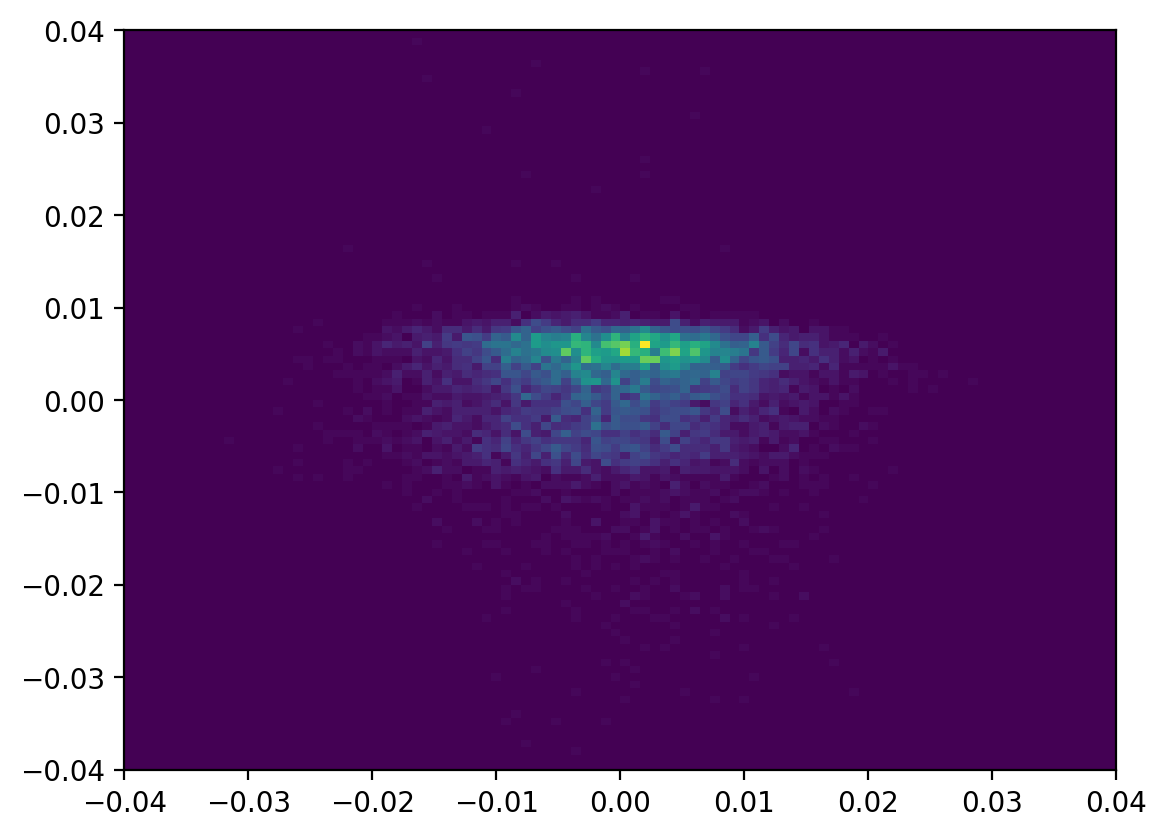

In [46]:
lattice = create_6d_diagnostic_beamline()
k_in = torch.tensor(10.0)
#bins = torch.linspace(-30, 30, 50) * 1e-3
lattice.elements[0].K1.data = k_in
lattice.elements[2].PHI0.data = torch.tensor(0)
lattice.elements[2].VOLTAGE.data = torch.tensor(0)
final_beam = lattice(input_beam)
plt.hist2d(final_beam.x.numpy(), final_beam.y.numpy(), bins=(100,100), range=[[-0.04, 0.04], [-0.04, 0.04]])